# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import miner
%matplotlib inline

## Create directory to save output files

In [2]:
# create name for results folder where output files will be saved
resultsFolder = "results_minCorrelation_0o2"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load previous results (skip if results have not previously been generated)

In [3]:
# If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))

## Pre-process expression data

In [4]:
reload(miner)
expressionFile = os.path.join(os.path.split(os.getcwd())[0],"data","IA12Zscore.csv")
expressionData, conversionTable = miner.preprocess(expressionFile)

completed identifier conversion.
16216 genes were converted.


## Set parameters

In [1486]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# number of cores available for multiprocessing
numCores = 5

## Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 5.41 minutes
Number of genes clustered: 15196
Number of unique clusters: 1233


Text(0,0.5,u'Number of clusters')

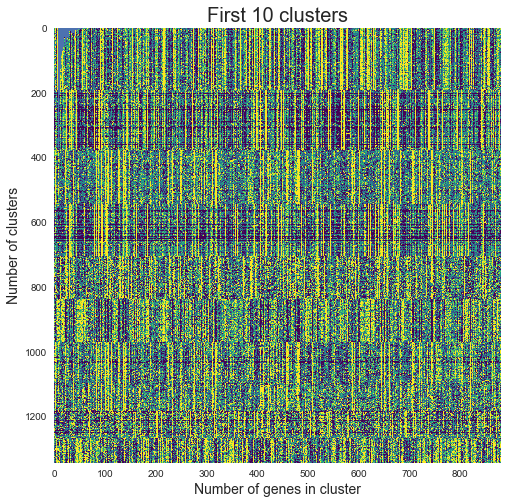

In [1487]:
t_start = time.time()
reload(miner)
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

# visualize first 10 clusters
plt.figure(figsize=(8,8))
plt.imshow(expressionData.loc[np.hstack([revisedClusters[i] for i in range(10)]),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 10 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

# plot histogram of the cluster size distribution
counts_ = plt.hist([len(revisedClusters[key]) for key in revisedClusters.keys()],bins=100)
plt.xlabel("Number of genes in cluster",FontSize=14)
plt.ylabel("Number of clusters",FontSize=14)

## Mechanistic inference (only supported for Homo Sapiens)

In [1488]:
reload(miner)
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print(len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique()))

0
246
247
248
249
1
492
493
494
495
250
739
2
740
741
251
742
252
496
986
987
253
743
497
988
498
254
989
499
744
255
500
990
745
991
501
746
256
502
992
257
747
3
258
993
994
503
259
995
748
996
504
997
749
505
998
260
506
261
507
750
999
508
1000
4
751
1001
262
509
1002
1003
1004
1005
510
1006
752
1007
511
1008
753
263
754
1009
512
264
1010
755
1011
513
265
5
1012
756
514
1013
1014
266
1015
515
1016
757
267
1017
1018
758
1019
268
516
1020
1021
269
759
517
1022
760
1023
518
1024
270
761
519
1025
762
1026
1027
1028
763
1029
271
1030
1031
520
6
1032
764
272
1033
521
765
522
766
1034
767
523
273
768
524
769
525
770
1035
771
274
526
1036
772
527
275
773
528
774
529
775
1037
530
776
276
7
531
277
532
1038
777
533
1039
778
534
278
535
779
1040
536
780
279
1041
781
8
782
1042
783
537
1043
280
784
281
785
538
1044
786
9
282
787
1045
539
788
1046
283
789
1047
284
540
790
1048
1049
791
285
10
541
1050
792
286
793
1051
542
287
794
1052
288
1053
795
543
1054
1055
796
11
289
544
797
1056
545
1057


## Infer bicluster membership

In [1489]:
reload(miner)
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

done!
done!
done!
done!


## Infer subtypes

done!
13
9
2
7
10
6
10
7
2
7
2
2
2
3
2
4
2
2
2
2
2
3
Discovered 26 transcriptional states and 67 transcriptional programs
sample coverage within sufficiently large states: 100.0%


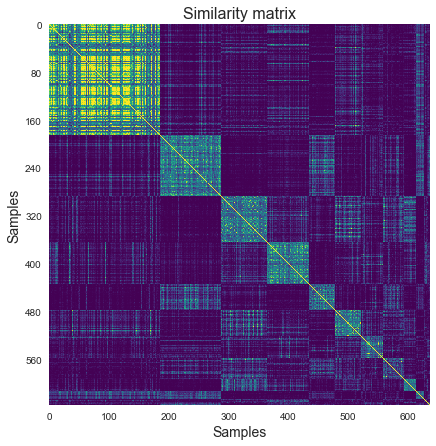

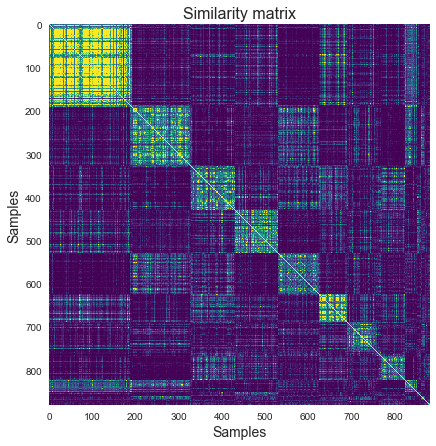

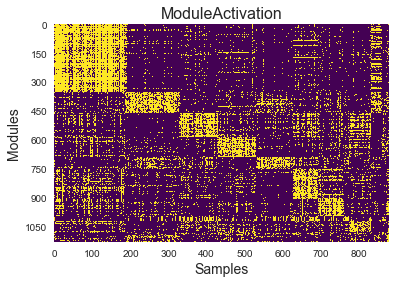

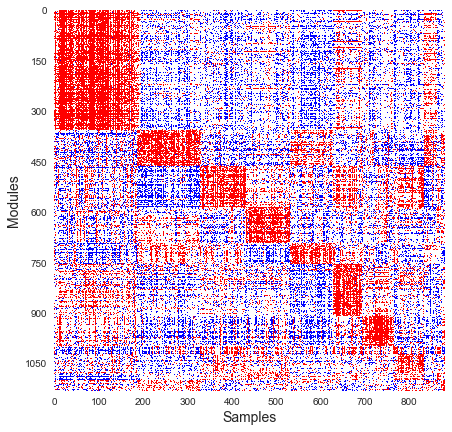

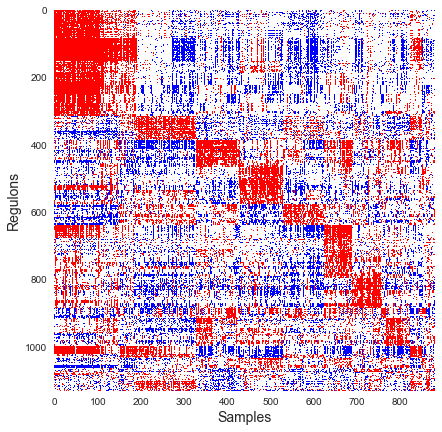

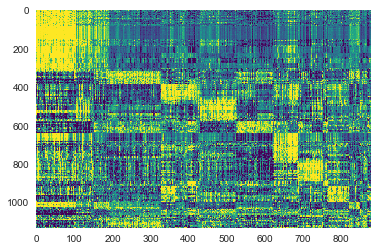

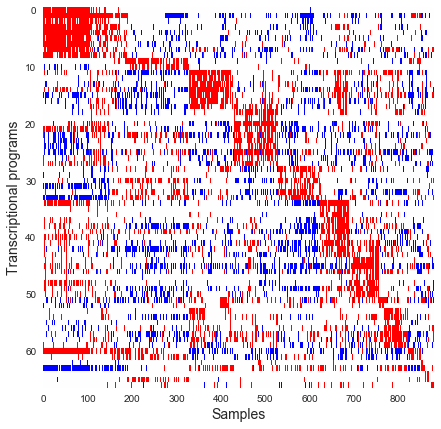

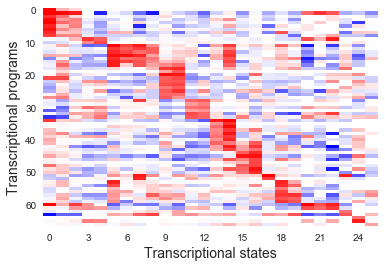

In [114]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))

# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",resultsDirectory=None)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"))

# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=9,minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

#plot eigengenes
plt.figure()
plt.imshow(eigengenes.loc[np.hstack(program_list),np.hstack(states)],cmap="viridis",vmin=-0.05,vmax=0.05,aspect="auto")
plt.grid(False)

# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=os.path.join(resultsDirectory,"transcriptional_programs_vs_samples.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"))

# Visualize with tSNE

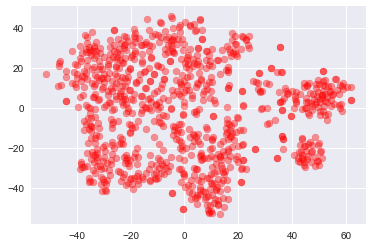

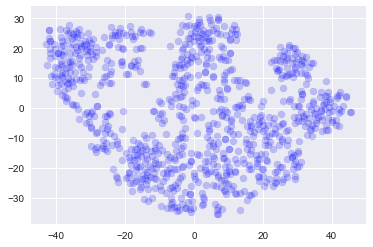

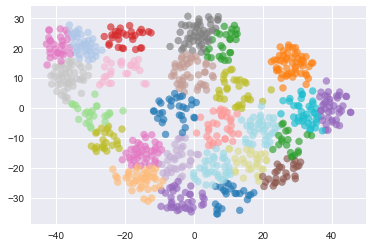

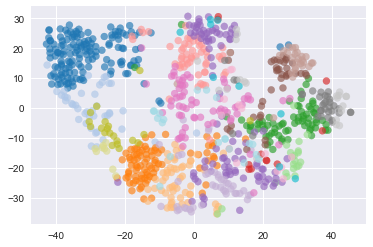

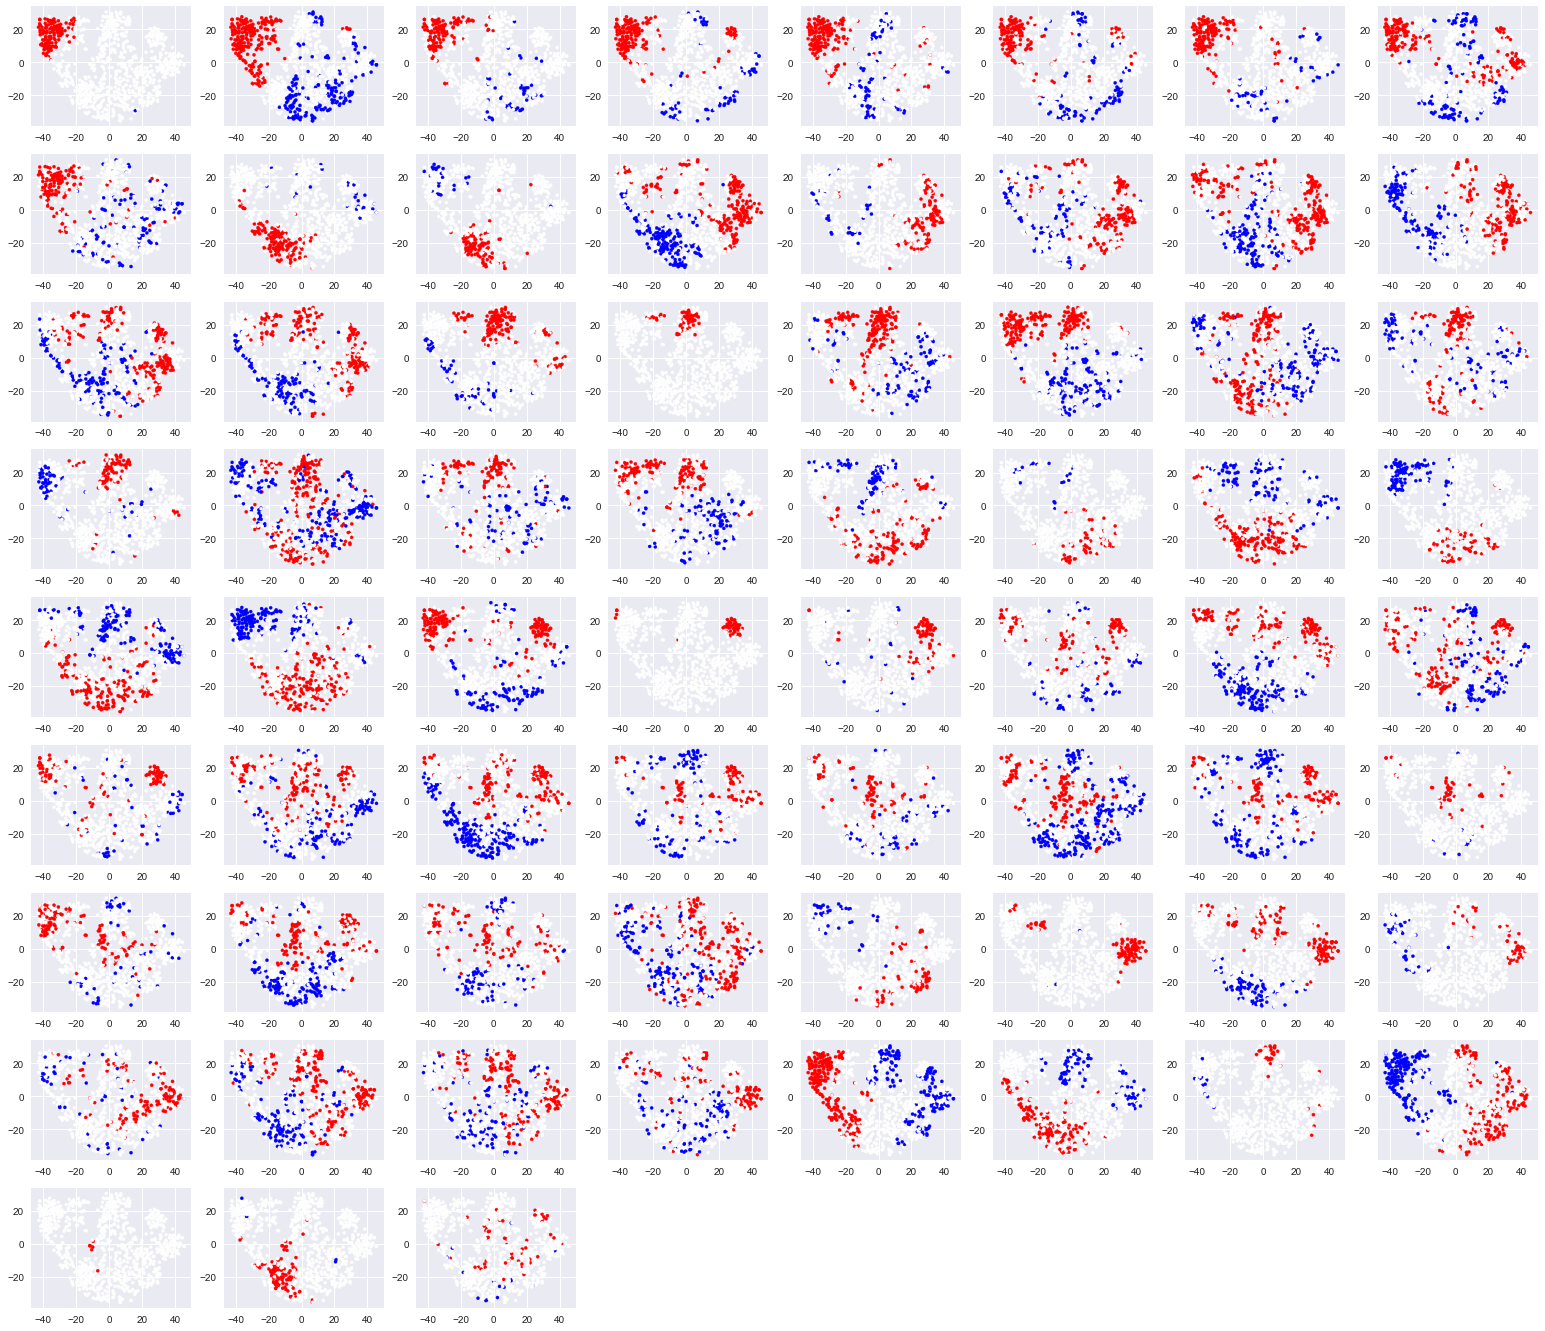

In [115]:
# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)
plt.savefig(os.path.join(resultsDirectory,"tsne_gene_expression.pdf"),bbox_inches="tight")

# tSNE applied to df_for_tsne. Consider changing the perplexity in the range of 5 to 50
df_for_tsne = mosaicDf.copy()
plt.figure()
X_embedded = miner.tsne(df_for_tsne,perplexity=30,n_components=2,n_iter=1000,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = df_for_tsne.columns
tsneDf.columns = ["tsne1","tsne2"]
plt.savefig(os.path.join(resultsDirectory,"tsne_regulon_activity.pdf"),bbox_inches="tight")

# How many clusters do you expect? Start with number of states
numberOfClusters = len(states)

# Are the clusters separated how you thought? If not, change the random_state to a different number and retry
random_state=12

clusters, labels, centroids = miner.kmeans(tsneDf,numClusters=numberOfClusters,random_state=random_state)

# overlay kmeans cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_kmeans.pdf"),bbox_inches="tight")

# convert states to tsne labels
state_labels = miner.tsneStateLabels(tsneDf,states)

# overlay states cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=state_labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_states.pdf"),bbox_inches="tight")

# overlay activity of transcriptional programs
miner.plotStates(statesDf,tsneDf,numCols=int(np.sqrt(statesDf.shape[0])),saveFile = os.path.join(resultsDirectory,("_").join(["states_regulons",("").join(["0o",str(minCorrelation).split(".")[1]]),"tsne.pdf"])),aspect=1,size=10,scale=3)

# Survival analysis

26
10
10
10
10
10


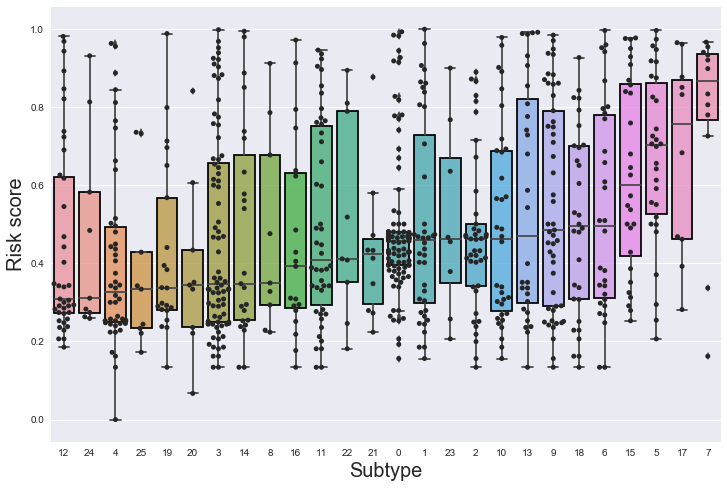

In [1631]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

mmrf_groups = states
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='group', y='value', data=guan_srv_df,order=ranked_states)
for patch in ax.artists:
    patch.set_edgecolor('black')
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

sns.swarmplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=5, color=[0.15,0.15,0.15],edgecolor="black")
    
plt.ylabel("Risk score",FontSize=20)
plt.xlabel("Subtype",FontSize=20)
boxplotFilename = ("_").join([survival_tag,"boxplot_swarm.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")


# proportional hazards regression of transcriptional programs
cox_programs = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=5,survivalPath="",survivalData=srv)

cox_programs_hr = [cox_programs[i][0] for i in range(len(cox_programs))]
cox_programs_p = [cox_programs[i][1] for i in range(len(cox_programs))]
cox_programs_df = pd.DataFrame(np.vstack([cox_programs_hr,cox_programs_p]).T)
cox_programs_df.index = [cox_programs.keys()[i] for i in range(len(cox_programs))]
cox_programs_df.columns = ["HR","p-value"]
cox_programs_df.sort_values(by="HR",ascending=False,inplace=True)

# proportional hazards regression of transcriptional states
state_members = [states[i] for i in range(len(states)) if len(states[i])>=9]
sufficient_states = [i for i in range(len(states)) if len(states[i])>=9]
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=5,survivalPath="",survivalData=srv)

cox_hr = [cox_states[i][0] for i in cox_states.keys()]
cox_p = [cox_states[i][1] for i in cox_states.keys()]
cox_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_df.index = cox_states.keys()
cox_df.columns = ["HR","p-value"]
cox_df.sort_values(by="HR",ascending=False,inplace=True)

## Combinatorial survival analysis

10
                               HR       p-value
7&17&5&15                7.193048  6.336065e-13
7&17&5&15&6              6.434706  1.237122e-10
7&17&5                   6.375667  1.821688e-10
7&17&5&15&6&18&9&13      6.017541  1.770869e-09
7&17&5&15&6&18&9         5.916930  3.280069e-09
7&17&5&15&6&18           5.801090  6.588533e-09
7&17&5&15&6&18&9&13&10   5.705035  1.163189e-08
7&17                     4.688570  2.751203e-06
7                        3.931769  8.432296e-05
12&24                   -1.278209  2.011758e-01
12                      -1.290130  1.970054e-01
12&24&4                 -2.692425  7.093451e-03
12&24&4&25              -3.014552  2.573592e-03
12&24&4&25&19           -3.389149  7.010989e-04
12&24&4&25&19&20        -3.745090  1.803288e-04
12&24&4&25&19&20&3      -4.091622  4.283658e-05
12&24&4&25&19&20&3&14   -4.245583  2.180257e-05
12&24&4&25&19&20&3&14&8 -4.263102  2.016083e-05


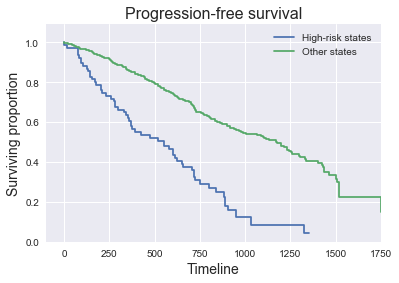

In [117]:
combined_states, combined_indices = miner.combinedStates(mmrf_groups,ranked_states,srv,minSamples=4,maxStates=10)

state_members = combined_states
sufficient_states = range(len(combined_states))
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_combined_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=1,survivalPath="",survivalData=srv)

cox_hr = [cox_combined_states[i][0] for i in cox_combined_states.keys()]
cox_p = [cox_combined_states[i][1] for i in cox_combined_states.keys()]
cox_combined_states_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_combined_states_df.index = combined_indices
cox_combined_states_df.columns = ["HR","p-value"]
cox_combined_states_df.sort_values(by="HR",ascending=False,inplace=True)
cox_combined_states_df.to_csv(os.path.join(resultsDirectory,"Hazards_regression_of_combined_transcriptional_states.csv"))
print(cox_combined_states_df)

highest_risk_combination = np.array(cox_combined_states_df.index[0].split("&")).astype(int)
lowest_risk_combination = np.array(cox_combined_states_df.index[-1].split("&")).astype(int)

kmTag = "states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [np.hstack([states[i] for i in highest_risk_combination]),np.hstack([states[i] for i in range(len(states)) if i not in highest_risk_combination])]
labels = np.arange(len(groups)).astype(str)
labels = ["High-risk states","Other states"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)    

In [ ]:
t_stop = time.time()
print("completed all modules in {:.2f} minutes".format((t_stop-t_start)/60.))

## Test dataset mapping template

In [216]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix


In [217]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

In [218]:
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

# # GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

# # EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)


completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!


In [219]:
# MMRFIA9
#expressionDataMMRFIA9 = pd.read_csv("/Users/MattWall/Desktop/IA12Files/dreamData/MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_TPM.txt",header=0,index_col=0,sep="\t")
expressionDataMMRFIA9 = expressionData.copy()
expressionDataMMRFIA9, conversionTable = miner.identifierConversion(expressionDataMMRFIA9)
expressionDataMMRFIA9 = miner.zscore(expressionDataMMRFIA9)

bkgdMMRFIA9 = miner.backgroundDf(expressionDataMMRFIA9)
overExpressedMembersMMRFIA9 = miner.biclusterMembershipDictionary(regulonModules,bkgdMMRFIA9,label=2,p=0.05)
overExpressedMembersMatrixMMRFIA9 = miner.membershipToIncidence(overExpressedMembersMMRFIA9,expressionDataMMRFIA9)


completed identifier conversion.
16216 genes were converted.
done!


In [220]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)

survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalGSE24080UAMS.head(3)
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]

survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalGSE19784HOVON65.head(3)
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]

survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalEMTAB4032.head(3)
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]

In [221]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDf)

## Decision tree predictor template

In [381]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import tree

In [382]:
srv2 = guanSurvivalDfGSE24080UAMS.copy()
mtrx2 = overExpressedMembersMatrixGSE24080UAMS.copy()
#mtrx2 = difference_complete_GSE24080UAMS.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv2.index[0:int(high_risk_cutoff*srv2.shape[0])])
lowRiskSamples = list(srv2.index[int(high_risk_cutoff*srv2.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix2 = pd.concat([mtrx2.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix2 = pd.concat([mtrx2.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix2 = pd.concat([hrMatrix2,lrMatrix2],axis=0)

predictionMatrix2.shape

(559, 3204)

In [383]:
srv3 = guanSurvivalDfGSE19784HOVON65.copy()
mtrx3 = overExpressedMembersMatrixGSE19784HOVON65.copy()
#mtrx2 = difference_complete_GSE24080UAMS.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv3.index[0:int(high_risk_cutoff*srv3.shape[0])])
lowRiskSamples = list(srv3.index[int(high_risk_cutoff*srv3.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix3 = pd.concat([mtrx3.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix3 = pd.concat([mtrx3.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix3 = pd.concat([hrMatrix3,lrMatrix3],axis=0)
predictionMatrix3.shape

(282, 3204)

In [384]:
srv4 = guanSurvivalDfEMTAB4032.copy()
mtrx4 = overExpressedMembersMatrixEMTAB4032.copy()
#mtrx2 = difference_complete_GSE24080UAMS.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv4.index[0:int(high_risk_cutoff*srv4.shape[0])])
lowRiskSamples = list(srv4.index[int(high_risk_cutoff*srv4.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix4 = pd.concat([mtrx4.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix4 = pd.concat([mtrx4.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix4 = pd.concat([hrMatrix4,lrMatrix4],axis=0)
predictionMatrix4.shape

(147, 3204)

In [385]:
srv5 = guanSurvivalDfMMRF.copy()
mtrx5 = overExpressedMembersMatrixMMRFIA9.copy()
#mtrx2 = difference_complete_GSE24080UAMS.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv5.index[0:int(high_risk_cutoff*srv5.shape[0])])
lowRiskSamples = list(srv5.index[int(high_risk_cutoff*srv5.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix5 = pd.concat([mtrx5.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix5 = pd.concat([mtrx5.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix5 = pd.concat([hrMatrix5,lrMatrix5],axis=0)
predictionMatrix5.shape

(769, 3204)

In [386]:
srv = guanSurvivalDfMMRF.copy()
mtrx = overExpressedMembersMatrix.copy()
#mtrx = difference_complete.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv.index[0:int(high_risk_cutoff*srv.shape[0])])
lowRiskSamples = list(srv.index[int(high_risk_cutoff*srv.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix = pd.concat([mtrx.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix = pd.concat([mtrx.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix = pd.concat([hrMatrix,lrMatrix],axis=0)
predictionMatrix.shape

#hrMatrixCombined = pd.concat([hrMatrix,hrMatrix2,hrMatrix3,hrMatrix4,hrMatrix5],axis=0)
#lrMatrixCombined = pd.concat([lrMatrix,lrMatrix2,lrMatrix3,lrMatrix4,lrMatrix5],axis=0)
hrMatrixCombined = pd.concat([hrMatrix,hrMatrix2,hrMatrix3,hrMatrix4],axis=0) # No MMRFIA9
lrMatrixCombined = pd.concat([lrMatrix,lrMatrix2,lrMatrix3,lrMatrix4],axis=0) # No MMRFIA9
predictionMatrixCombined = pd.concat([hrMatrixCombined,lrMatrixCombined],axis=0)
predictionMatrixCombined.head()

0    1    2    3    4    5    6    7    8    9   ...     \
MMRF_2754_1_BM  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_2151_1_BM  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_1450_1_BM  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_1634_1_BM  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_1778_1_BM  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   ...      

                3194  3195  3196  3197  3198  3199  3200  3201  3202  HR_FLAG  
MMRF_2754_1_BM   1.0   0.0   0.0   1.0   1.0   1.0   1.0   0.0   1.0        1  
MMRF_2151_1_BM   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
MMRF_1450_1_BM   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0        1  
MMRF_1634_1_BM   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
MMRF_1778_1_BM   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  

[5 rows x 3204 columns]

In [387]:
predictionMatrix = predictionMatrixCombined

X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

best_state = 0
best_f1 = 0
best_auc = 0
aucs = []
for rs in range(100):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = rs)

    clf_gini_pp2 = DecisionTreeClassifier(criterion = "gini", random_state = 12, max_depth=6, min_samples_leaf=5)#12
    
    clf_gini_pp2.fit(X_train, y_train)

    y_pred = clf_gini_pp2.predict(X_test)
    
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)
    aucs.append(auc)

    #print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
    print("F1-score is ", f1)
    print("ROC AUC is ", auc)
    
    if f1 > best_f1:
        best_f1 = f1
        
    if auc > best_auc:
        best_auc = auc        
        best_state = rs

print(best_state,best_auc)    
print(np.argsort(-np.array(aucs)))
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = best_state)

('F1-score is ', 0.3009708737864078)
('ROC AUC is ', 0.5736111111111111)
('F1-score is ', 0.26737967914438504)
('ROC AUC is ', 0.5616952426131743)
('F1-score is ', 0.21965317919075145)
('ROC AUC is ', 0.5438203994195288)
('F1-score is ', 0.3333333333333333)
('ROC AUC is ', 0.5867847454419279)
('F1-score is ', 0.25870646766169153)
('ROC AUC is ', 0.5527821460835814)
('F1-score is ', 0.3101604278074866)
('ROC AUC is ', 0.5827669652970857)
('F1-score is ', 0.2275449101796407)
('ROC AUC is ', 0.5505980618053673)
('F1-score is ', 0.1752577319587629)
('ROC AUC is ', 0.5153130781965137)
('F1-score is ', 0.36199095022624433)
('ROC AUC is ', 0.6024929399162527)
('F1-score is ', 0.2616822429906542)
('ROC AUC is ', 0.5497614178595774)
('F1-score is ', 0.3522727272727273)
('ROC AUC is ', 0.6055896762283443)
('F1-score is ', 0.19780219780219782)
('ROC AUC is ', 0.5329563056667097)
('F1-score is ', 0.3225806451612903)
('ROC AUC is ', 0.588501291989664)
('F1-score is ', 0.28431372549019607)
('ROC AUC

In [777]:
predictionMatrix = predictionMatrixCombined

X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = 65) #75
clf_gini_pp2 = DecisionTreeClassifier(criterion = "gini", random_state = 12, max_depth=6, min_samples_leaf=5)
clf_gini_pp2.fit(X_train, y_train)
#clf_gini.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

In [778]:
y_pred = clf_gini_pp2.predict(X)
y_pred

print("Accuracy is ", accuracy_score(Y,y_pred)*100)
print("F1-score is ", f1_score(Y,y_pred))
print("ROC AUC is ", roc_auc_score(Y,y_pred))

('Accuracy is ', 84.4621513944223)
('F1-score is ', 0.553191489361702)
('ROC AUC is ', 0.7090947756577233)


In [779]:
y_pred = clf_gini_pp2.predict(X_train)
y_pred

print("Accuracy is ", accuracy_score(y_train,y_pred)*100)
print("F1-score is ", f1_score(y_train,y_pred))
print("ROC AUC is ", roc_auc_score(y_train,y_pred))

('Accuracy is ', 87.47810858143608)
('F1-score is ', 0.6433915211970075)
('ROC AUC is ', 0.7595508052285693)


In [780]:
y_pred = clf_gini_pp2.predict(X_test)
y_pred

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
print("F1-score is ", f1_score(y_test,y_pred))
print("ROC AUC is ", roc_auc_score(y_test,y_pred))

('Accuracy is ', 78.86178861788618)
('F1-score is ', 0.380952380952381)
('ROC AUC is ', 0.6152528846473581)


In [781]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf_gini_pp2, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf(os.path.join(resultsDirectory,"decisionTreeAUC.pdf"))

In [393]:
predictor_tag = "IA12"
mmrfIA9_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixMMRFIA9.T))
mmrfIA12_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixMMRF.T))
GSE24080UAMS_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

In [773]:
lbls = EMTAB4032_predictions
mtrx = overExpressedMembersMatrixEMTAB4032
srv = survivalDfEMTAB4032.copy()
survival_tag = "EMTAB4032"

hr_dt = mtrx.columns[lbls.astype(bool)]
lr_dt = mtrx.columns[(1-lbls).astype(bool)]

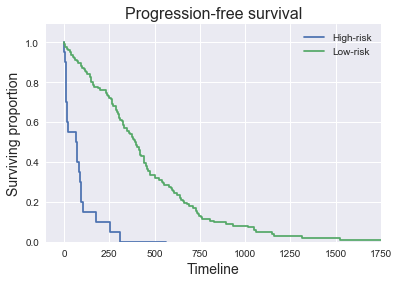

In [774]:
reload(miner)
kmTag = "decision_tree"
kmFilename = ("_").join([survival_tag,predictor_tag,kmTag,"high-risk",".pdf"])

groups = [hr_dt,lr_dt]
labels = ["High-risk","Low-risk"]

plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)   

In [775]:
cox_vectors = []
srv_set = set(srv.index)
for i in range(len(groups)):
    group = groups[i]
    patients = list(set(group)&srv_set)
    tmp_df = pd.DataFrame(np.zeros(srv.shape[0]))
    tmp_df.index = srv.index
    tmp_df.columns = [labels[i]]
    tmp_df.loc[patients,labels[i]] = 1
    cox_vectors.append(tmp_df)
    
pre_cox = pd.concat(cox_vectors,axis=1).T
pre_cox.head(5)
    
cox_dict = miner.parallelMemberSurvivalAnalysis(membershipDf = pre_cox,numCores=1,survivalPath="",survivalData=srv)
print(cox_dict)

/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['High-risk'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['Low-risk'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)

{'High-risk': (6.647126525832355, 2.9887010621625984e-11), 'Low-risk': (-6.647126525832355, 2.9887010621625984e-11)}


In [824]:
# calculate percent of high-risk samples
print(100*len(hr_dt)/float(mtrx.shape[1]))

13.6054421769


In [751]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_predictor.sav')
pickle.dump(clf_gini_pp2, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8067796610169492
